In [1]:
import numpy as np
import matplotlib.pyplot as plt
import galois
import itertools
from classical_code import *
from quantum_code import *
import stim
from scipy.sparse import lil_matrix
import scipy as sp
from ldpc import bposd_decoder, bp_decoder
from tqdm import tqdm
from result_lifetime import Result, save_new_res
# %load_ext snakeviz

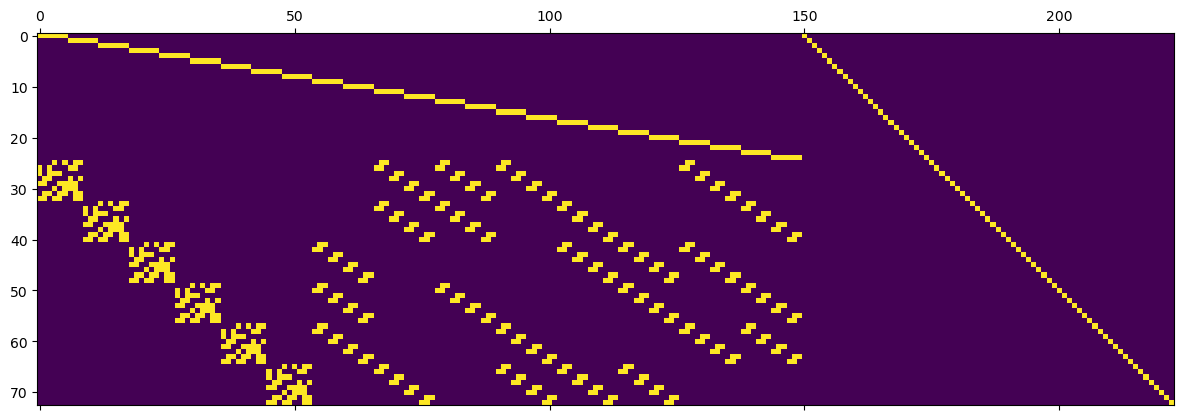

In [20]:
qcode = read_qcode("../codes/qcodes/HGP_100_4.qcode")
qcode = read_qcode("../codes/qcodes/HGP_C642_150_4.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_C422_200_4.qcode")
# qcode = read_qcode("./codes/qcodes/HGP_C752_140_4.qcode")


# qcode = read_qcode("../codes/qcodes/HGP_400_16.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_900_36.qcode")
# qcode = read_qcode("../codes/qcodes/HGP_C642_1350_36.qcode")

# qcode = read_qcode("../codes/qcodes/HGP_1600_64.qcode")


# qcode = read_qcode("./codes/qcodes/HGP_C642_600_16.qcode")
# qcode = read_qcode("./codes/qcodes/HGP_C422_800_16.qcode")

# qcode = read_qcode("./codes/qcodes/HGP_Surface_1300_4.qcode")

Hx, Hz, Lx, Lz = qcode.to_numpy()

Hx = np.hstack([Hx, np.eye(Hx.shape[0], dtype=int)])

plt.matshow(Hx)

In [34]:
overlapping_x_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedxm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedxm,qcode.xm):
        if np.any(Hx[i] & Hx[j]): tmp = np.append(tmp, j)
    overlapping_x_generators[i] = tmp

overlapping_z_generators = np.empty(qcode.qedxm, dtype=object)
for i in range(qcode.qedzm):
    tmp = np.array([], dtype=int)
    for j in range(qcode.qedzm,qcode.zm):
        if np.any(Hz[i] & Hz[j]): tmp = np.append(tmp, j)
    overlapping_z_generators[i] = tmp

def get_overlapping(measurements, gen_type=False, not_overlapping=False):
    overlapping_generators = overlapping_x_generators if gen_type else overlapping_z_generators
    gens_to_measure = set()
    for g in np.where(measurements)[0]:
        gens_to_measure |= set(overlapping_generators[g])

    if not_overlapping:
        return np.array(list(set(np.arange(qcode.qedxm,qcode.xm)) ^ gens_to_measure))
    else:
        return np.array(list(gens_to_measure))

In [40]:
qubit_error_rate = 0.01
meas_error_rate = 0.01

if (qcode.qedxm):
    bp_qed_dec = bp_decoder(
        Hx[:qcode.qedxm], # the parity check matrix
        error_rate=qubit_error_rate,
        # channel_probs=new_channel_probs, #assign error_rate to each qubit. This will override "error_rate" input variable
        max_iter=100, #pcm.shape[1], #the maximum number of iterations for BP)
        bp_method="msl",
        ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
        # osd_method="osd0", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
        # osd_order=40 #the osd search depth
    )

bposd_qed_qec_dec = bposd_decoder(
    Hx,
    error_rate=qubit_error_rate,
    bp_method="msl",
    max_iter=Hx.shape[1],
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd0", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    # osd_order=40 #the osd search depth
)

bposd_qec_dec = bposd_decoder(
    Hx,
    error_rate=qubit_error_rate,
    # channel_probs=Hx.shape[1]*[qubit_error_rate],
    bp_method="msl",
    max_iter=Hx.shape[1],
    ms_scaling_factor=0, #min sum scaling factor. If set to zero the variable scaling factor method is used
    osd_method="osd0", #the OSD method. Choose from:  1) "osd_e", "osd_cs", "osd0"
    # osd_order=4 #the osd search depth
)

In [147]:
concat = 0
adaptive = 1

# num_gens_measured = []

rs = []
tmp = []
for ii in tqdm(range(1,1001)):
    num_rounds = 0
    residual_error = np.zeros(Hx.shape[1], dtype=int)

    while True:
        num_rounds += 1
        new_qubit_error = np.random.choice([0, 1], size=Hx.shape[1], p=[1-qubit_error_rate, qubit_error_rate])
        new_synd_error = np.random.choice([0, 1], size=Hx.shape[0], p=[1-meas_error_rate, meas_error_rate])
        curr_qubit_error = residual_error ^ new_qubit_error
        curr_synd = ((Hx @ curr_qubit_error) % 2) ^ new_synd_error

        updated_synd = curr_synd.copy()
        non_overlapping_gens = get_overlapping(curr_synd[:qcode.qedxm], True, True)
        # num_gens_measured.append(qcode.xm - len(non_overlapping_gens))
        if (len(non_overlapping_gens)):
            updated_synd[non_overlapping_gens] = 0

        # QEC
        if (concat == 0):
            if (adaptive == 1):
                guessed_error = bposd_qec_dec.decode(updated_synd[qcode.qedxm:])
            else:
                guessed_error = bposd_qec_dec.decode(curr_synd[qcode.qedxm:])
        elif (concat == 1):
            # QED + QEC
            _ = bp_qed_dec.decode(curr_synd[:qcode.qedxm])

            ######################## # THIS MIGHT NEED TO CHANGE SLIGHTLY, SOFT INFORMATION DECODING
            # new_channel_probs = np.exp(-bp_qed_dec.log_prob_ratios)
            new_channel_probs = 1 / (np.exp(bp_qed_dec.log_prob_ratios) + 1)
            new_channel_probs = new_channel_probs / np.sum(new_channel_probs) / num_rounds # DIVIDED BY NUM_ROUNDS IMPROVES IT FOR SOME REASON !!!!!!!!!!!!
            bposd_qed_qec_dec.update_channel_probs(new_channel_probs)
            ########################

            if (adaptive == 1):
                guessed_error = bposd_qed_qec_dec.decode(updated_synd[qcode.qedxm:])
            else:
                guessed_error = bposd_qed_qec_dec.decode(curr_synd[qcode.qedxm:])


        residual_error = curr_qubit_error ^ guessed_error
        # residual_synd = (Hx @ residual_error) % 2
        # ideal_correction = bposd_qec_dec.decode(residual_synd[qcode.qedxm:])

        obs = [np.count_nonzero(residual_error[l]) % 2 for l in qcode.Lz]
        # obs = [np.count_nonzero((ideal_correction ^ residual_error)[l]) % 2 for l in qcode.Lz]

        if np.any(obs):
            break

    res = Result(concat, adaptive, qcode.n, qcode.k, qubit_error_rate, meas_error_rate, 1, num_rounds, 0)
    rs.append(res)
    tmp.append(num_rounds)

    if (ii%100==0):
        save_new_res('tmp.res', rs)
        rs = []
print(np.mean(tmp))

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 2069.78it/s]

1.419


In [53]:
concat = 1
adaptive = 0
successes = 0

def decode(curr_synd, concat, adaptive):
    guessed_error = np.zeros(Hx.shape[1], dtype=int)
    updated_synd = curr_synd.copy()
    non_overlapping_gens = get_overlapping(curr_synd[:qcode.qedxm], True, True)
    if (len(non_overlapping_gens)):
        updated_synd[non_overlapping_gens] = 0

    if (concat == 0):
        # QEC only
        if (adaptive == 1):
            guessed_error = bposd_qec_dec.decode(updated_synd)
        else:
            guessed_error = bposd_qec_dec.decode(curr_synd)
    elif (concat == 1):
        # QED + QEC
        _ = bp_qed_dec.decode(curr_synd[:qcode.qedxm])

        ######################## # THIS MIGHT NEED TO CHANGE SLIGHTLY, SOFT INFORMATION DECODING
        # new_channel_probs = np.exp(-bp_qed_dec.log_prob_ratios)
        new_channel_probs = 1 / (np.exp(bp_qed_dec.log_prob_ratios) + 1)
        new_channel_probs = new_channel_probs / np.sum(new_channel_probs)
        bposd_qed_qec_dec.update_channel_probs(new_channel_probs)
        ########################

        if (adaptive == 1):
            guessed_error = bposd_qed_qec_dec.decode(updated_synd) # bposd_qed_qec_dec or bposd_qec_dec
        else:
            guessed_error = bposd_qed_qec_dec.decode(curr_synd)

    return guessed_error

for ii in range(1,10001):
    if (ii % 1000 == 0): print('*', end='')
    curr_qubit_error = np.zeros(Hx.shape[1], dtype=int)

    success = 1
    success2 = 1
    for jj in range(1):
        curr_qubit_error[Hx.shape[1]-Hx.shape[0]:] = 0
        new_qubit_error = np.random.choice([0, 1], size=Hx.shape[1]-Hx.shape[0], p=[1-qubit_error_rate, qubit_error_rate])
        new_synd_error = np.random.choice([0, 1], size=Hx.shape[0], p=[1-meas_error_rate, meas_error_rate])
        curr_qubit_error ^= np.hstack([new_qubit_error, np.array([0] * Hx.shape[0])])
        curr_synd = ((Hx @ curr_qubit_error) % 2) ^ new_synd_error

        guessed_error = decode(curr_synd, concat, adaptive)

        curr_qubit_error ^= guessed_error

    curr_qubit_error[Hx.shape[1]-Hx.shape[0]:] = 0
    curr_synd = ((Hx @ curr_qubit_error) % 2)

    # guessed_error = bposd_qec_dec.decode(curr_synd)
    guessed_error = decode(curr_synd, concat, 0)

    curr_qubit_error ^= guessed_error
    curr_synd = ((Hx @ curr_qubit_error) % 2)

    # print()
    obs = (Lx @ curr_qubit_error[:Hx.shape[1]-Hx.shape[0]]) % 2

    if np.any(obs) or np.any(curr_synd):
        success = 0

    successes += success

print()
print(successes)

**********
9900
